# Imports & basics

In [ ]:
# -- path info --
path_to_repo = "/Users/mbaranov/python_wd/credit_scoring_project"
dataset_nm = "02_australian"

# -- experiments logging --
experiment_dir = "test"
! mkdir "test"
# -- --

n_total = 200
top_k = 20

load = False                       # whether to train models or load from json

In [1]:
# --- base ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json
import importlib
import optuna
optuna.logging.set_verbosity(1)   # default 20

import sys
seed = 89

# --- sklearn ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# --- modules ---
sys.path.insert(1, path_to_repo)  # directory with modules
from feature_engine.encoding import RareLabelEncoder, MeanEncoder
from modules.feature_selection import SafeSelectByShuffling
from modules.encoders import WoEEncoder_adj

import modules.optuna_instruments
from modules.optuna_instruments import optimized_function, get_top_k_models, get_top_test_scores



# --- load data ---
X_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_train.parquet")
y_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_train.parquet")["target"]
X_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_test.parquet")
y_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_test.parquet")["target"]
with open(f"{path_to_repo}/datasets/{dataset_nm}/factors.json", "r") as f:
    factors = json.load(f)

sample_info = {
    "X_train" : X_train,
    "y_train" : y_train,
    "X_test" : X_test, 
    "y_test" : y_test,
    "loss" : roc_auc_score
}

In [2]:
# 1 row with category 3 in each df
X_train["A4"] = X_train["A4"].clip(1, 2)
X_test["A4"] = X_test["A4"].clip(1, 2)

# Baseline pipeline

## Run models

In [4]:
# baseline modules
rare_encoder = RareLabelEncoder(variables=["A4"], ignore_format=True, n_categories=1)
setattr(rare_encoder, "pipeline_nm", "rare")

mean_encoder = MeanEncoder(variables=factors["cat_vals"], ignore_format=True)
setattr(mean_encoder, "pipeline_nm", "cat_feat_MeanEnc")

woe_encoder = WoEEncoder_adj(variables=factors["cat_vals"], ignore_format=True)
setattr(woe_encoder, "pipeline_nm", "cat_feat_WoEEnc")


sel_shuffl = SafeSelectByShuffling(estimator=LogisticRegression(max_iter=1000, solver="newton-cg"), min_features=1, variables=None, random_state=seed)
setattr(sel_shuffl, "pipeline_nm", "feat_sel_SelShuffl")

logreg = LogisticRegression(max_iter=1000, random_state=seed, solver="newton-cg")
setattr(logreg, "pipeline_nm", "classifier_LogReg")

# no choice for baseline pipeline
stages_options_baseline = {
    # "rare" : [rare_encoder],
    "cat_feat" : [woe_encoder],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : [],
    "classifier" : [logreg]
}

# hparameters only for classifier
hparams_options_baseline = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [5]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "r") as f:
        baseline_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_baseline = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed) 
        )

    strategy="kfold"
    study_baseline.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_baseline, hparams_options=hparams_options_baseline, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    baseline_results = [
        {"value" : study_baseline.trials[i].value, "params" : study_baseline.trials[i].params} for i in range(len(study_baseline.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "w") as f:
        json.dump(baseline_results, f)

[I 2022-04-28 14:21:44,791] A new study created in memory with name: no-name-b7445c04-a0d2-4412-a604-5c32ce8d1d44
[I 2022-04-28 14:21:44,983] Trial 0 finished with value: 0.90059248631702 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 50}. Best is trial 0 with value: 0.90059248631702.
[I 2022-04-28 14:21:45,158] Trial 1 finished with value: 0.90063233965673 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 1 with value: 0.90063233965673.
[I 2022-04-28 14:21:45,331] Trial 2 finished with value: 0.90063233965673 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 1 with value: 0.90063233965673.
[I 2022-04-28 14:21:45,505] Trial 3 finished with value: 0.90059248631702 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 1 with value: 0.90063233965673.
[I 2022-04-28 14:21:45,682] Trial 

## Results

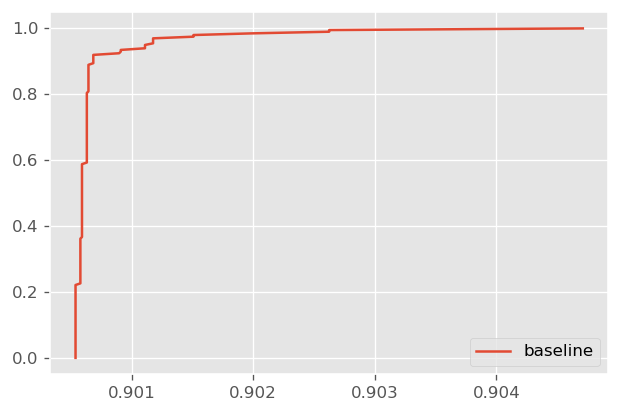

In [6]:
plt.figure(dpi=120)

auc_values_baseline = np.array([elem["value"] for elem in baseline_results])
t = np.linspace(0, 1, n_total)

plt.plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
plt.legend()

# plt.plot(auc_values);

In [7]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_baseline = get_top_test_scores(baseline_results, top_k=top_k, stages_options=stages_options_baseline, **sample_info)
print(scores_baseline)

  0%|          | 0/20 [00:00<?, ?it/s]

[0.89408133 0.89408133 0.89408133 0.89408133 0.89408133 0.89408133
 0.89408133 0.89408133 0.89408133 0.89408133 0.89408133 0.89408133
 0.89408133 0.89408133 0.89408133 0.89408133 0.89344262 0.89344262
 0.89344262 0.89344262]


# Categorical encoding

## Run models

In [8]:
from feature_engine.encoding import DecisionTreeEncoder, CountFrequencyEncoder, OneHotEncoder
OHE_encoder = OneHotEncoder(
    variables=factors["cat_vals"], drop_last_binary=True, ignore_format=True
)
setattr(OHE_encoder, "pipeline_nm", "cat_feat_OHE")

# -- --

stages_options_encoding = {
    "rate" : [rare_encoder],
    "cat_feat" : [mean_encoder, woe_encoder, OHE_encoder],  # changes only here
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg]
}

hparams_options_encoding = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [9]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "r") as f:
        encoding_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_encoding = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_encoding.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_encoding, hparams_options=hparams_options_encoding, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    encoding_results = [
        {"value" : study_encoding.trials[i].value, "params" : study_encoding.trials[i].params} for i in range(len(study_encoding.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "w") as f:
        json.dump(encoding_results, f)

[I 2022-04-28 14:22:33,812] A new study created in memory with name: no-name-f35df963-b867-4659-9a9f-77930a9ff336
[I 2022-04-28 14:22:34,007] Trial 0 finished with value: 0.9141293373718051 and parameters: {'rate': 0, 'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.9141293373718051.
[I 2022-04-28 14:22:34,190] Trial 1 finished with value: 0.9141293373718051 and parameters: {'rate': 0, 'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 0 with value: 0.9141293373718051.
[I 2022-04-28 14:22:34,528] Trial 2 finished with value: 0.9115787236303736 and parameters: {'rate': 0, 'cat_feat': 2, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 36}. Best is trial 0 with value: 0.9141293373718051.
[I 2022-04-28 14:22:34,706] Trial 3 finished with value: 0.90059248631702 and parameters: {'rate': 0, 'cat_feat': 1, 'feat_sel': 0, 'imb_data': 0, 'classifie

## Results

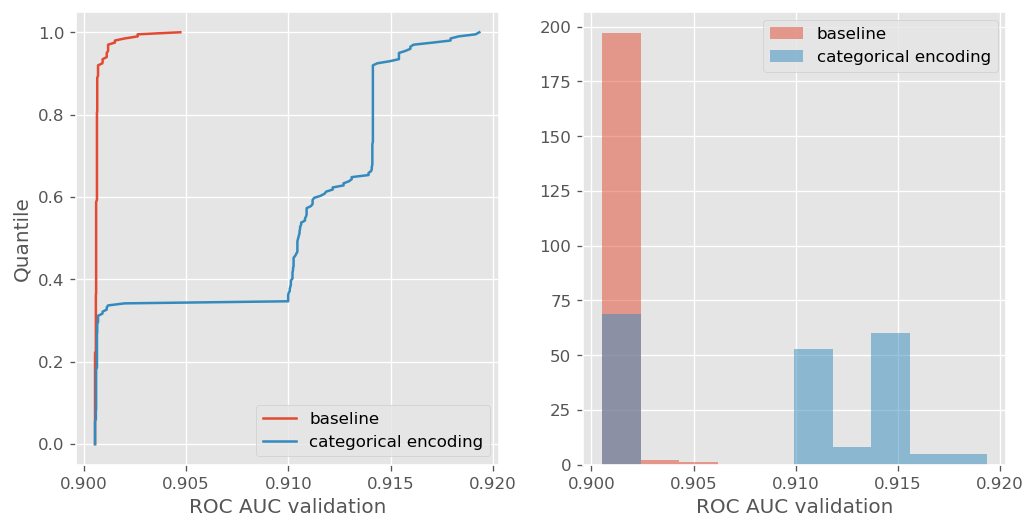

In [10]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_encoding = np.array([elem["value"] for elem in encoding_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_encoding])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_encoding), t, c="C1", label="categorical encoding")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_encoding, bins=bin_edges, alpha=0.5, label="categorical encoding")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [11]:
scores_encoding = get_top_test_scores(encoding_results, top_k=top_k, stages_options=stages_options_encoding, **sample_info)
print(np.mean(
    scores_encoding.reshape(-1, 1) >= scores_baseline
))

print(f"mean diff {np.mean(scores_encoding) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1.0
mean diff 0.016872


# Feature selection

## Run models

In [16]:
from modules.feature_selection import SafeSelectBySingleFeaturePerformance
from feature_engine.selection import SmartCorrelatedSelection

# -- additional feature selection options --
SinglePerf_module = SafeSelectBySingleFeaturePerformance(  # rather slow
    estimator=LogisticRegression(max_iter=500),
    scoring="roc_auc",
    threshold=None,               # will be automatically set to the mean performance value of all features
    # min_features=5
)
setattr(SinglePerf_module, "pipeline_nm", "feat_sel_SinglePerf")

SmartSel_module = SmartCorrelatedSelection(
    variables=None,                  # If None, the transformer will evaluate all numerical variables in the dataset.  -- нужен класс.
    method="pearson",                # can be replaced by a custom function
    threshold=0.3,                   # correlation threshold
    selection_method="variance",     # select feature with greatest variance from a correlated group
    estimator=None,                  # for selection_method="model_performance"        
    cv=5
)
setattr(SmartSel_module, "pipeline_nm", "feat_sel_SmartSel")
# --- ---

stages_options_feat_sel = {
    "rare" : [rare_encoder],
    "cat_feat" : [woe_encoder],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl, SinglePerf_module, SmartSel_module],  # changes only here
    "imb_data" : [],
    "classifier" : [logreg]
}

hparams_options_feat_sel = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "feat_sel_SinglePerf" : lambda trial: {
        "feat_sel_SinglePerf__threshold" : trial.suggest_float("feat_sel_SinglePerf__threshold", low=0.5, high=0.6)
    }
}

In [17]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "r") as f:
        feat_sel_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # -- run grid search --
    study_feat_sel = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_feat_sel.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_feat_sel, hparams_options=hparams_options_feat_sel, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    feat_sel_results = [
        {"value" : study_feat_sel.trials[i].value, "params" : study_feat_sel.trials[i].params} for i in range(len(study_feat_sel.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "w") as f:
        json.dump(feat_sel_results, f)

[I 2022-04-28 14:30:47,935] A new study created in memory with name: no-name-c8fe4772-27f1-4a6b-a206-de002a6ca842
[I 2022-04-28 14:30:48,387] Trial 0 finished with value: 0.9091048468038722 and parameters: {'rare': 0, 'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.9091048468038722.
[I 2022-04-28 14:30:48,856] Trial 1 finished with value: 0.9091048468038722 and parameters: {'rare': 0, 'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 0 with value: 0.9091048468038722.
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:291: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correl

## Results

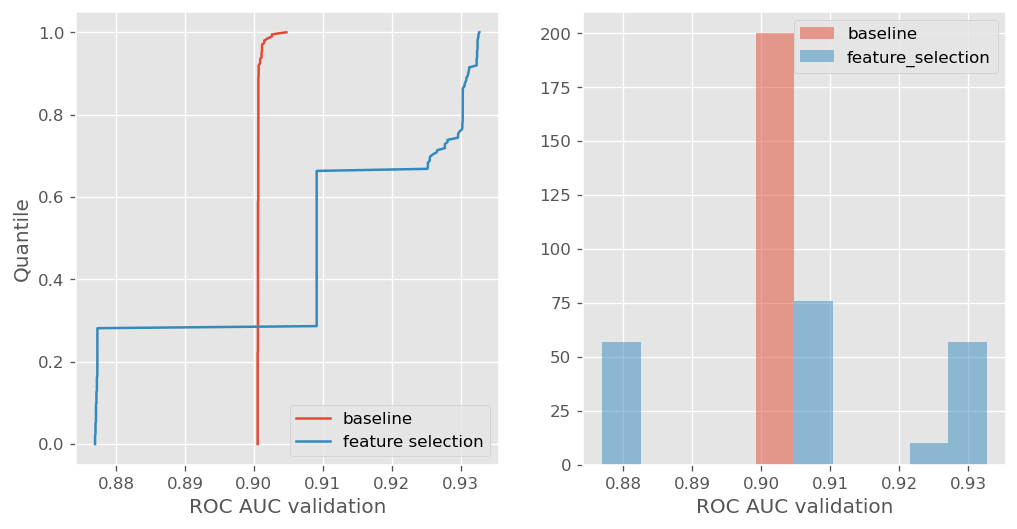

In [18]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_feat_sel = np.array([elem["value"] for elem in feat_sel_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_feat_sel])


ax[0].plot(np.sort(auc_values_baseline), np.linspace(0, 1, len(auc_values_baseline)), c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_feat_sel), np.linspace(0, 1, len(auc_values_feat_sel)), c="C1", label="feature selection")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_feat_sel, bins=bin_edges, alpha=0.5, label="feature_selection")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [19]:
scores_feat_sel = get_top_test_scores(feat_sel_results, top_k=top_k, stages_options=stages_options_feat_sel, **sample_info)
print(scores_feat_sel)
print(np.mean(
    scores_feat_sel.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_feat_sel) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.92186502 0.92143922 0.92143922 0.92165212 0.92165212 0.92165212
 0.92165212 0.92165212 0.92165212 0.92165212 0.92165212 0.92165212
 0.92165212 0.92165212 0.92165212 0.92165212 0.92165212 0.90887801
 0.90887801 0.90887801]
1.0
mean diff 0.025772


# Classifier choice

## Run models

In [45]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced")  # drop random_state :))
setattr(RF_classifier, "pipeline_nm", "classifier_RF")

stages_options_classifier = {
    "cat_feat" : [woe_encoder],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg, RF_classifier]  # changes only here
}

hparams_options_classifier = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "classifier_RF" : lambda trial: {
        "classifier_RF__max_depth" : trial.suggest_categorical("classifier_RF__max_depth", [2, 4, 8, 16]),
    },
}

In [46]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "r") as f:
        classifier_results = json.load(f)
else:
    # -- run grid search --
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    study_classifier = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_classifier.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_classifier, hparams_options=hparams_options_classifier, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=200,
        # timeout=100,
        )

    # -- save results to json --
    classifier_results = [
        {"value" : study_classifier.trials[i].value, "params" : study_classifier.trials[i].params} for i in range(len(study_classifier.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "w") as f:
        json.dump(classifier_results, f)

[I 2022-04-28 14:54:02,445] A new study created in memory with name: no-name-74c5da0f-cfa6-41fe-be6e-6d8343cb8681
[I 2022-04-28 14:54:02,888] Trial 0 finished with value: 0.9091048468038722 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.9091048468038722.
[I 2022-04-28 14:54:03,550] Trial 1 finished with value: 0.9014327156563313 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_RF__max_depth': 8}. Best is trial 0 with value: 0.9091048468038722.
[I 2022-04-28 14:54:04,206] Trial 2 finished with value: 0.9036361281688773 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_RF__max_depth': 8}. Best is trial 0 with value: 0.9091048468038722.
[I 2022-04-28 14:54:04,855] Trial 3 finished with value: 0.9107080585803861 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_RF__max_depth': 4

## Results

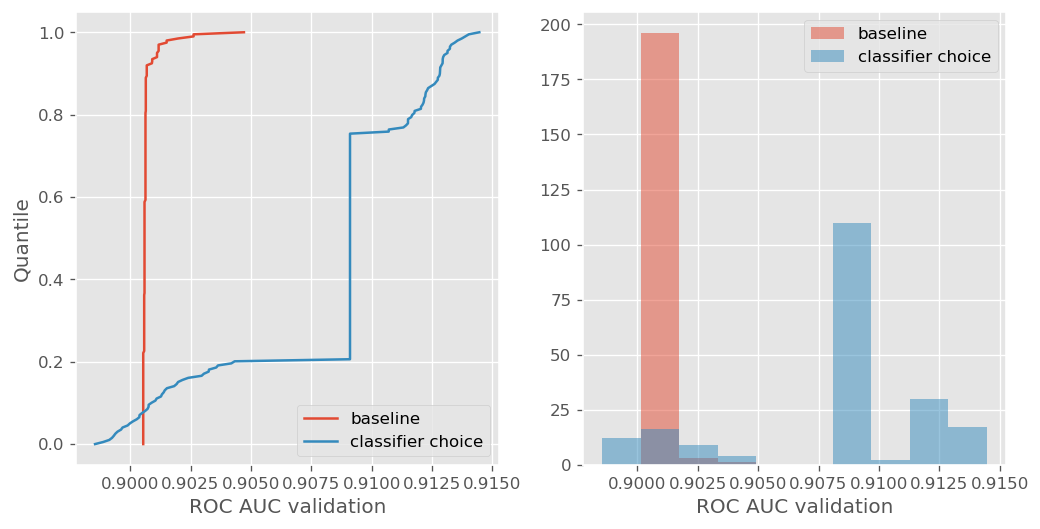

In [47]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_classifier = np.array([elem["value"] for elem in classifier_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_classifier])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_classifier), t, c="C1", label="classifier choice")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_classifier, bins=bin_edges, alpha=0.5, label="classifier choice")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [48]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_classifier = get_top_test_scores(classifier_results, top_k=top_k, stages_options=stages_options_classifier, **sample_info)
print(scores_classifier)
print(np.mean(
    scores_classifier.reshape(-1, 1) > scores_baseline
))
print(f"mean diff {np.max(scores_classifier) - np.max(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.88311688 0.88631041 0.89248456 0.88290398 0.88599106 0.89078135
 0.88588461 0.88631041 0.88343624 0.88450075 0.88662976 0.88620396
 0.89035555 0.88450075 0.8852459  0.88567171 0.88758782 0.88396849
 0.88364914 0.88992974]
0.0
mean diff -0.001597
